## ANUSPLIN10km: ASCII grid --> Netcdf 


Agriculture and Agri-Food Canada have produced daily precipitation, minimum and maximum temperature across Canada (south of 60°N) for climate related application purpose using thin-plate smoothing splines, as implemented in the ANUSPLIN climate modeling software (Hutchinson et al., 2009; McKenney et al., 2011). 

The so-called ANUSPLIN data uses ground-based observations and generates daily gridded data from 1951 to 2017 on a Lambert conformal conic projection with 5’ arc minutes spacing (equivalent to a resolution of about 10 km). The key strength of this spatial interpolation method is its global dependence on all data, permitting robust and stable determination of spatially varying dependences on elevation. Hutchinson et al. (2009) have shown that while ANUSPLIN fall month’s absolute errors were remarkably small, those of winter months were quite large due to rather difficult observation and measurement conditions.

However, the recent comparison between various (ANUSPLIN and other) gridded observed products shows compatible values for mean total precipitation, wet days occurrence and mean/extreme intensity of daily precipitation, over both southern Canada and eastern USA in winter (e.g. Diaconescu et al., 2016). 


Data are available on: 

ftp://ftp.nrcan.gc.ca/pub/outgoing/canada_daily_grids

This dataset is only availabe with ascii grid format, I'll here show how to convert into Netcdf using Python. 

- can_ascgrids_dly_metadata.txt file gives information on Gridded 10km Canada Daily Temperature and Precipitation Dataset. 


NumPy has the ability to read the ASCIIGRID format directly using its loadtxt() method designed to read arrays from text files. The first six lines of min1950_1.asc consist of the header, which are not part of the array. The following lines are a sample of a grid header:


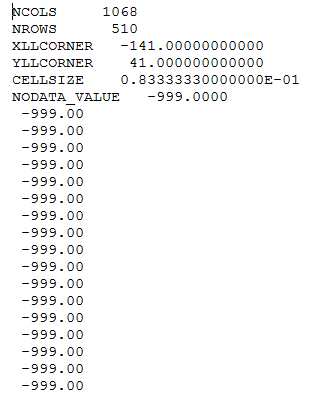


Line 1 contains the number of columns in the grid, which is synonymous with the x axis. Line 2 represents the y axis described as a number of rows. Line 3 represents the x coordinate of the lower left corner, which is the minimum x value. Line 4 is the corresponding minimum y value in the lower left corner of the grid. Line 5 is the cell size or resolution of the raster. Because the cells are square, only one size value is needed, as opposed to the separate x and y resolution values in most geospatial rasters. The fifth line is no data value, which is a number assigned to any cell for which a value is not provided. 


In [1]:
import os
import pandas as pd 
import numpy as np
from netCDF4 import Dataset, date2num
from datetime import datetime, timedelta, date

cur_dir = os.path.realpath(os.path.dirname('__file__'))

path = './ascii_grid'
variable = 'min'

Function to read ascci_grid information and return informations. 

In [3]:
def read_grd(filename):
    with open(filename) as infile:
        ncols = int(infile.readline().split()[1])
        nrows = int(infile.readline().split()[1])
        xllcorner = float(infile.readline().split()[1])
        yllcorner = float(infile.readline().split()[1])
        cellsize = float(infile.readline().split()[1])
        nodata_value = float(infile.readline().split()[1])
        
    longitude = xllcorner + cellsize * np.arange(ncols)
    latitude = yllcorner + cellsize * np.arange(nrows)
    value = np.loadtxt(filename, skiprows=6)

    return longitude, latitude, value, ncols, nrows, nodata_value


We will work only with january 1950  and make a loop over every days. 

All years are formatted as leap years with 29 days for February. The asciigrids for Julian day 60 are missing in the non-leap years.

In [14]:
for year in range(1950,1951):
    path =  'ascii_grid/canada_daily' + str(year) + '/' + str(year)
    for month in range(1,2):
        if  month == 1:
            dmin, dmax =(1,31)
        elif month == 2:
            if year % 4 == 0 :
                dmin, dmax =(32,60)
            else:
                dmin, dmax =(32,59)
        elif month == 3:
            dmin, dmax =(61,91)
        elif month == 4:
            dmin, dmax =(92,121)
        elif month == 5:
            dmin, dmax =(122,152)
        elif month == 6:
            dmin, dmax =(153,182)
        elif month == 7:
            dmin, dmax =(183,213)
        elif month == 8:
            dmin, dmax =(214,244)
        elif month == 9:
            dmin, dmax =(245,274)
        elif month == 10:
            dmin, dmax =(275,305)
        elif month == 11:
            dmin, dmax =(306,335)
        elif month == 12:
            dmin, dmax =(336,366)
        
        field = []
        for d in range(dmin,dmax+1):           
            fichier = variable + str(year) + '_' + str(d) + '.asc'                                  
            fichier = os.path.join(cur_dir, path, fichier)        
            longitude, latitude, value, ncols, nrows, nodata_value = read_grd(fichier)                 
            xx, yy = np.meshgrid(longitude, latitude)
            zz = np.reshape(value, ( nrows, ncols))[::-1]
            zz[zz==nodata_value]=np.nan
            field.append(zz)
            
        concatenated = np.dstack(field)

        start = date(year, month, 1)
        rng = pd.date_range(start, periods= (dmax - dmin +1), freq='D')
        tot = dmax - dmin +1
        
        ###### Write Netcdf File 
        C = Dataset('./netcdf_grid/ANUSPLIN_10km_tasmin_ll_'+str(year)+"_{:02d}".format(month)+'.nc', 'w', format="NETCDF4")
        C.description = 'ANUSPLIN data'
        C.conventions = 'CF-1.0'  
        C.model_id = 'ANUSPLIN_10km'
        C.grid='latlon'
        C.institution = 'UQAM - ESCER Center, University of Quebec in Montreal'
        C.contact = 'Guillaume Dueymes'
        ########################################
        # Dimensions
        C.createDimension('x', ncols)
        C.createDimension('y', nrows)
        C.createDimension('time', tot)
        
        var=C.createVariable('Tasmin', np.float32, ('y','x','time')) 
        var.long_name = 'Daily_minimum_temperature'
        var.unit = 'Celcius'
        latitude=C.createVariable('latitude', np.float32, ('y','x'))
        longitude=C.createVariable('longitude', np.float32, ('y','x')) 
        latitude.units = 'degrees north'
        longitude.units = 'degrees east'
        
        # Write time dimension
        time = C.createVariable('time', np.float64, ('time',))
        time.long_name = 'time'
        time.units = 'days since ' + str(year) + '-' + '{:02d}'.format(int(month))+'-01 00:00:00.0'
        time.calendar = "proleptic_gregorian"
        dates = [datetime(year,month,1)+n*timedelta(days=1) for n in range(concatenated.shape[2])]
        time[:] = date2num(dates,units=time.units,calendar=time.calendar)
        
        # Write latlon informations
        setattr(C.variables['latitude'],'Latitude','Lat')
        setattr(C.variables['longitude'],'Longitude','Lon')
         
        latitude[:,:] = yy
        longitude[:,:] = xx
        C.variables['Tasmin'][:,:,:] = concatenated[::]
        C.close()

Result: 

<img src="./Tasmin_in_ANUSPLIN_10km_tasmin_ll_1950_01.png" alt="Seaborn" width="60%" height="70%">